In [2]:
# for database and dataframe
import sqlite3
import pandas as pd

# for plotting and processing
from tqdm import tqdm
import matplotlib.pyplot as plt

# utils for I/O with database
import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.utils import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

In [3]:
# For ML part
import torch
import torchvision
import numpy as np
print("GPU connected: ", torch.cuda.is_available())
torch.cuda.empty_cache()

import torch
# mac neural engine
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
    x = torch.ones(1, device=device)
    print (x)
# cuda device
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("Neither MPS device nor CUDA devices available.")

GPU connected:  False
Neither MPS device nor CUDA devices available.


# Load dataframe from database

In [20]:
con = sqlite3.connect('./simulations.db')
simulations= pd.read_sql_query("SELECT * from simulations", con)
beta_approximations = pd.read_sql_query("SELECT * from beta_approximations", con)
con.close()

In [21]:
# analyse per seed
seed = 1001
simulations = simulations[simulations['seed'] == seed]
# simulation_id is the unique identifier for each simulation and identifyer in beta_approximations
beta_approximations = beta_approximations[beta_approximations['simulation_id'].isin(simulations['simulation_id'])]

In [22]:
# merge the two dataframes according to simulation_id (which only keeps the ones where analysis was done so far!!)
df = pd.merge(simulations, beta_approximations, on='simulation_id')
# remove unnessary columns (raw_file, dataset, mu)
df

,simulation_id,N,K,lambda,mu,h,window,seed,raw_file,dataset,a,b,loc,scale
0,1,10000,100,0.0000,0.2,1.000000e+00,0.000001,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1e-06,3.000801e+03,2.072159e+04,-0.0001,1.0002
1,2,10000,100,0.0000,0.2,1.000000e+00,1.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,6.499563e+03,4.488178e+04,-0.0001,1.0002
2,3,10000,100,0.0000,0.2,1.000000e+00,10.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,5.995206e+04,4.139902e+05,-0.0001,1.0002
3,4,10000,100,0.0000,0.2,1.000000e+00,100.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,5.947034e+05,4.106638e+06,-0.0001,1.0002
4,5,10000,100,0.0000,0.2,1.000000e+00,1000.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,5.693645e+06,3.931665e+07,-0.0001,1.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,3158,10000,100,0.9999,0.2,5.623413e-07,1.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1.0,2.826496e-01,2.242160e+02,-0.0001,1.0002
3158,3159,10000,100,0.9999,0.2,5.623413e-07,10.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/10.0,2.830932e-01,2.246287e+02,-0.0001,1.0002
3159,3160,10000,100,0.9999,0.2,5.623413e-07,100.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/100.0,2.857805e-01,2.274708e+02,-0.0001,1.0002
3160,3161,10000,100,0.9999,0.2,5.623413e-07,1000.000000,1001,/scratch02.local/johannes/projects/sahel_finit...,samples/1000.0,2.991431e-01,2.448752e+02,-0.0001,1.0002


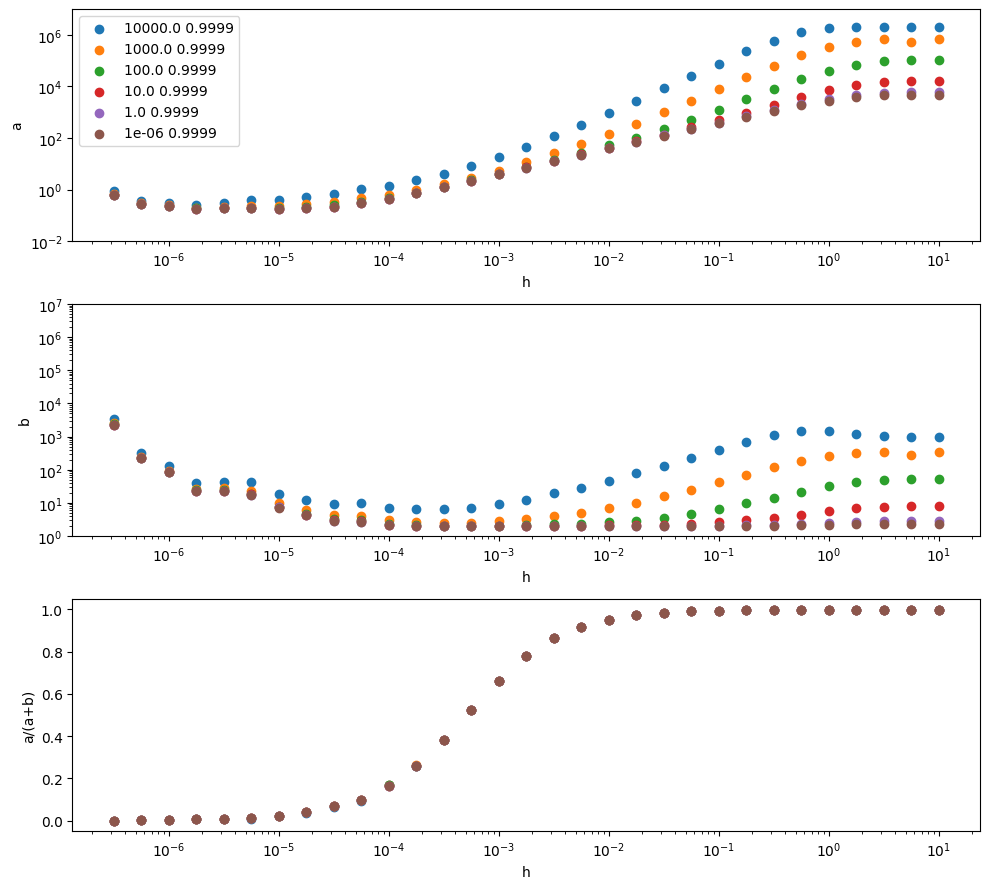

In [29]:
# plot beta parameters for different windows and lambdas from dataframe
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
windows = df["window"].unique()
lambdas = df["lambda"].unique()
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
lam=0.9999
for window in sorted(windows)[::-1]:
#for lam in lambdas[::4]:
    df_temp = df[(df["window"] == window) & (df["lambda"] == lam)]
    axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / (df_temp["a"]+df_temp["b"]) , label="{} {}".format(window, lam))

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/(a+b)")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
# axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
#axes[2].set_ylim(1e-8, 1e4)

axes[0].legend(loc='upper left')
plt.tight_layout()

Fit the available data with a deep neural network that maps system parameters (h,epsilon) to beta-distribution parameters (a,b)

In [12]:
import sklearn
from sklearn.preprocessing import MinMaxScaler

def get_data(dataframe, shuffle=1234):
    # x data is a stack of the columns (window, lam, h)
    X = dataframe[["window", "lambda", "h"]].values
    # transform into log space
    X[:,0] = np.log10(X[:,0])
    X[:,1] = np.log10(1-X[:,1])
    X[:,2] = np.log10(X[:,2])
    # y data is a stack of the columns (a, b, loc, scale)
    Y = dataframe[["a", "b", "loc", "scale"]].values
    # transform a, b, into log space
    Y[:,0] = np.log10(Y[:,0])
    Y[:,1] = np.log10(Y[:,1])
    print(X.shape, Y.shape)
    # shuffle with random mask
    mask = np.arange(len(X))
    # if shuffle is not False:
    if shuffle is not None:
        np.random.seed(shuffle)
        np.random.shuffle(mask)
    return X[mask], Y[mask], 
get_data(df, shuffle=None)

(8364, 3) (8364, 4)


(array([[ 0.  ,  0.  , -4.  ],
        [ 0.  ,  0.  , -4.  ],
        [ 0.  ,  0.  , -3.9 ],
        ...,
        [-6.  , -4.  , -6.25],
        [-6.  , -4.  ,  0.8 ],
        [-6.  , -4.  ,  0.9 ]]),
 array([[ 1.17050535e+00,  5.09144856e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.16959498e+00,  5.09031048e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 1.12108882e+00,  5.02370911e+00, -1.00000000e-04,
          1.00020000e+00],
        ...,
        [-5.48829940e-01,  2.35057763e+00, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67610401e+00,  3.75814863e-01, -1.00000000e-04,
          1.00020000e+00],
        [ 3.67686155e+00,  3.75932646e-01, -1.00000000e-04,
          1.00020000e+00]]))

We follow here the [simple example](https://notebook.community/kit-cel/lecture-examples/mloc/ch3_Deep_Learning/pytorch/function_approximation_with_MLP) using pytorch

Define the model

TODO: In principle we know the $h->0$ and $h->\infty$ solution from the $T->\infty$ solution. Can we make use of this?

(8364, 3) (8364, 4)


100%|██████████| 10000/10000 [00:32<00:00, 311.75it/s]


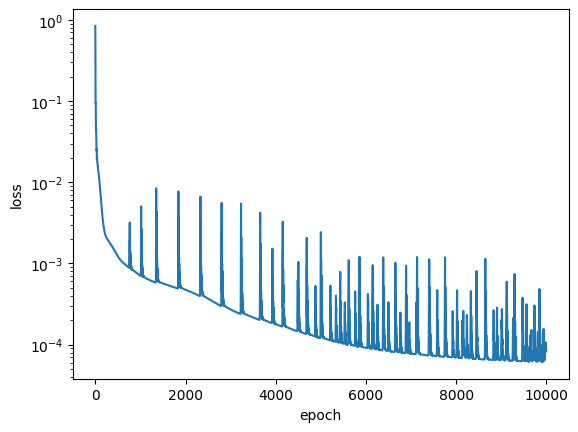

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(3, 42)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(42, 42)
        self.act2 = nn.Tanh()
        self.hidden3 = nn.Linear(42, 42)
        self.act3 = nn.Tanh()
        self.output = nn.Linear(42, 4)
        #self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.output(x)
        return x
 

def train_model_simple(X_train, Y_train, epochs):
    """
    Trains a simple neural network with one hidden layer with units neurons
    """
    # prepare data
    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()

    # create model
    model = NeuralNetwork()

    # Adam and MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss(reduction='mean')
    
    # main loop    
    history_loss = []
    for epoch in tqdm(range(epochs)):
        yhat = model(X_train_tensor)
        loss = loss_fn(yhat, Y_train_tensor)
        history_loss.append(loss.item())
        # compute gradients
        loss.backward() 
        # carry out one optimization step with Adam
        optimizer.step()   
        # reset gradients to zero
        optimizer.zero_grad()

    return model, history_loss

# rescale data (can use the same scaler multiple times using fit_transform function)
X_scaler = MinMaxScaler(feature_range=(-1, 1))
Y_scaler = MinMaxScaler(feature_range=(-1, 1))
X, Y = get_data(df)
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

# train model
model, loss = train_model_simple(X_scaled, Y_scaled, 10000)
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.show()


In [ ]:
# simple API to get Y=[a,b,loc,scale] from X=[h, window, lambda]
# TODO

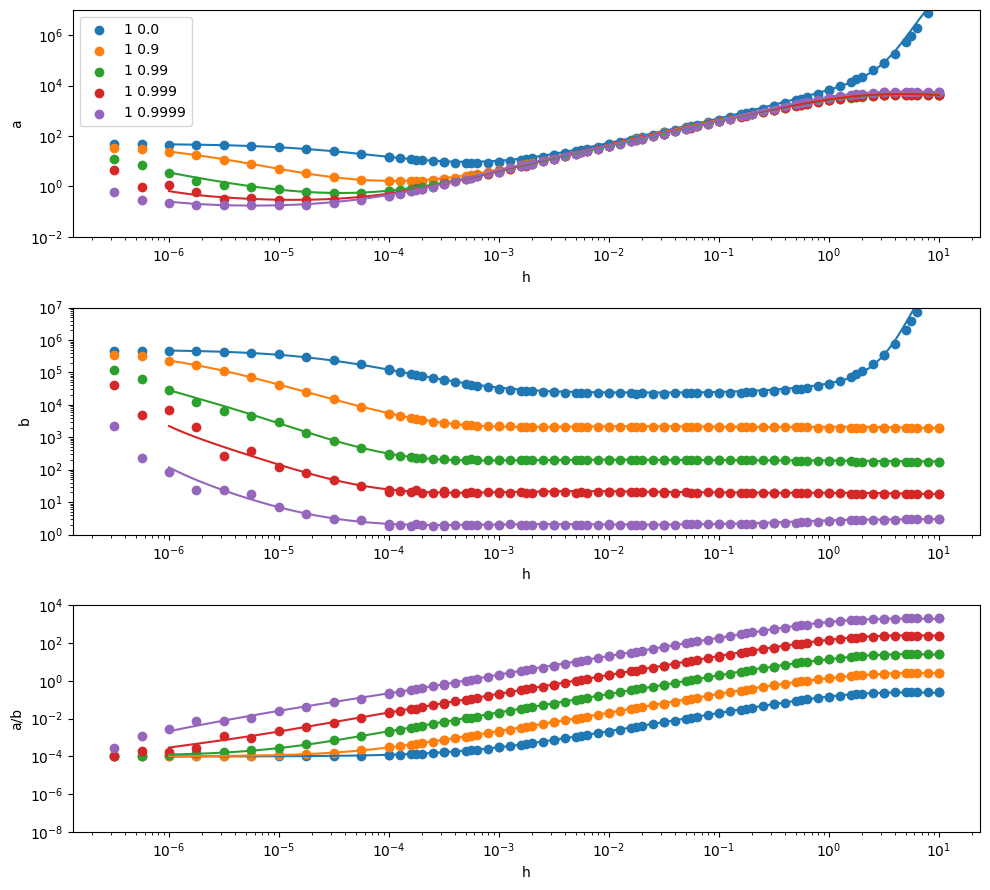

In [16]:
import itertools
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# mesh grid for contour plot
log10hs = np.linspace(-6, 1, 200)

windows = df["window"].unique()
lambdas = np.sort(df["lam"].unique())
hs = df["h"].unique()
seeds = df["seed"].unique()
# reverse the order of the windows

window=1
#lam=0.9
#for window in sorted(windows)[::-1]:
for lam in lambdas[::4]:
    df_temp = df[(df["window"] == window) & (df["lam"] == lam)]
    X_model = np.dstack([np.log10(window)*np.ones_like(log10hs), np.log10(1-lam)*np.ones_like(log10hs), log10hs]).reshape(-1, 3)
    X_model_scaled = X_scaler.transform(X_model)
    Y_model_scaled = model(torch.from_numpy(X_model_scaled).float()).detach().numpy()
    Y_model = Y_scaler.inverse_transform(Y_model_scaled)

    a_model = 10**Y_model[:, 0]
    b_model = 10**Y_model[:, 1]

    ref = axes[0].scatter(df_temp["h"].values, df_temp["a"], label="{} {}".format(window, lam))
    axes[0].plot(10**log10hs, a_model, color=ref.get_facecolor()[0])
    axes[1].scatter(df_temp["h"].values, df_temp["b"], label="{} {}".format(window, lam))
    axes[1].plot(10**log10hs, b_model, color=ref.get_facecolor()[0])
    axes[2].scatter(df_temp["h"].values, df_temp["a"] / df_temp["b"], label="{} {}".format(window, lam))
    axes[2].plot(10**log10hs, a_model/b_model, color=ref.get_facecolor()[0])

axes[0].set_xlabel("h")
axes[1].set_xlabel("h")
axes[2].set_xlabel("h")
axes[0].set_ylabel("a")
axes[1].set_ylabel("b")
axes[2].set_ylabel("a/b")

axes[0].set_yscale("log")
axes[1].set_yscale("log")
axes[2].set_yscale("log")

axes[0].set_xscale("log")
axes[1].set_xscale("log")
axes[2].set_xscale("log")

axes[0].set_ylim(1e-2, 1e7)
axes[1].set_ylim(1e0, 1e7)
axes[2].set_ylim(1e-8, 1e4)

axes[0].legend(loc='upper left')
plt.tight_layout()

In [ ]:
#TODO: Save model to load it later

### Convolution of beta distribution with Guassian 

In [28]:
delta = 1/N
support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

def ml_pmf(window, lam, h, verbose=False):
    # distribution is given by Beta-distribution specified by a and b
    X = np.log10(np.array([window, 1-lam, h]))
    X_scaled = X_scaler.transform(X.reshape(-1,1).T)
    Y_scaled = model(torch.from_numpy(X_scaled).float()).detach().numpy()
    log10a, log10b, loc, scale = Y_scaler.inverse_transform(Y_scaled).T.reshape(-1)
    a,b = 10**log10a, 10**log10b
    # pmf as difference of cdf!
    pmf_beta = np.diff(stats.beta.cdf(support, a, b, loc=loc, scale=scale))
    # check for special cases with vanishing pmf
    if np.sum(pmf_beta) < 0.9:
        print(f'ERROR: (a,b)=({a},{b}) vanishing beta distribution with sum(pmf)={np.sum(pmf_beta)}')
    # check for special cases that result in delta distribution (find any pmf_beta to be infinity)
    if np.any(pmf_beta==np.inf):
        if verbose:
            print(f'WARNING: (a,b)=({a},{b}) infinity encountered in beta distribution, converted to pmf with single probable state')
        mask = pmf_beta==np.inf
        pmf_beta[mask] = 1
        pmf_beta[~mask] = 0
        if np.sum(pmf_beta) != 1:
            print("ERROR: pmf not normalized to 1")
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    # convolution with a Gaussian distribution at every point of the support
    return np.convolve(pmf_beta, pmf_norm, mode="same")

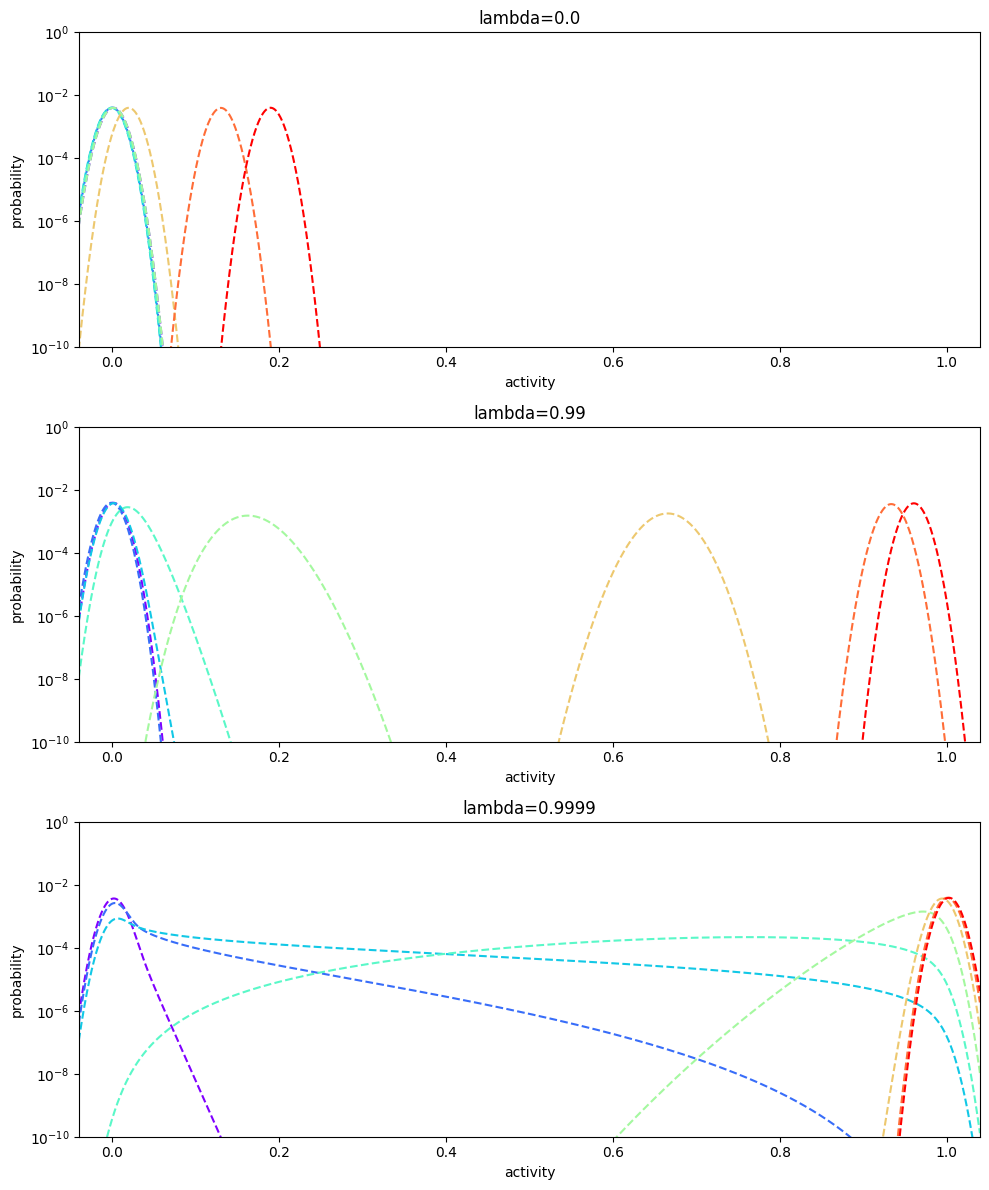

In [30]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.99, 0.9999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-6, 1, 8)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        #a,b,loc,scale = df.loc[ (df['window']==1) & (df['lam']==lam) & (df['h']==h) ].values[0][4:]
        c = next(color)
        #pmf_beta = stats.beta.pdf(support, a, b, loc=loc, scale=scale)*delta
        #axes[i].plot(support, pmf_beta, color=c)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.1331748644298757, 0.2865449875299475, 0.4675815276496617, 0.6914168685682575, 0.985452592587438, 1.410212464771393]
hs_right:  [1.9154080991118272, 1.2835553839130276, 0.9016237386617926, 0.6292180770577176, 0.41821032047159346, 0.24533405344519746]


(-0.04, 1.04)

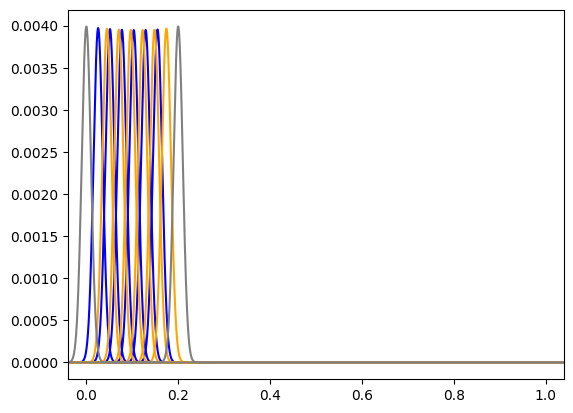

In [ ]:
# test discriminable intervals
lam = 0.0
window = 1 
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! 
h_range=[10**-7,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above and needs to be consistent with the ml_pmf function!
print(a_inf(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

In [33]:
lams = np.sort(df['lam'].unique())[::4]

# analysis parameters
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))
mis = np.zeros(len(lams))

# need to exclude the zero here because of logh fit
h_range=[10**-7, 10]

for i, lam in tqdm(enumerate(lams), total=len(lams)):
    print(i,lam)
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return ml_pmf(window, lam, h)
    pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
    pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    # print(hs_left,hs_right)
    if len(hs_left) > 0 and len(hs_right) > 0:
        drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        drs[i] = 0
        nds[i] = 0


  0%|          | 0/5 [00:00<?, ?it/s]

0 0.0


 20%|██        | 1/5 [02:03<08:14, 123.71s/it]

1 0.9


 20%|██        | 1/5 [07:54<31:36, 474.17s/it]


KeyboardInterrupt: 

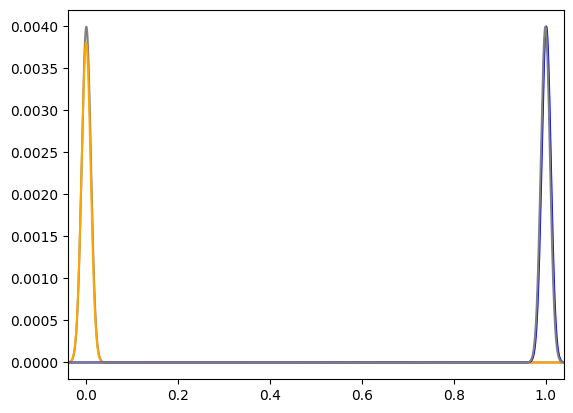

hs from left
possible solution: h=0.00014642244268902262 with overlap to end of 0.00036131173848048966 ... accepted
possible solution: h=0.0014391328045296468 with overlap to end of 0.009653638781501717 ... accepted
possible solution: h=0.010411023009432 with overlap to end of 0.11969698048953048 ... rejected
hs from right
possible solution: h=0.00872620972947351 with overlap to end of 1.677185009280933e-32 ... accepted
possible solution: h=0.0012114569363611786 with overlap to end of 2.977564726885441e-06 ... accepted
possible solution: h=0.00011427100958522482 with overlap to end of 0.12901152231231267 ... rejected
[0.00014642244268902262, 0.0014391328045296468]


In [24]:
# check large lambda in more detail why there is no discriminable points when coming from left
lam = 0.0
window=1
def pmf_o_given_h(h):
    return ml_pmf(window, lam, h)
h_range=[10**-7, 10]
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_o_given_h(h_range[0]), color="orange")
plt.plot(support, pmf_o_given_h(h_range[-1]), color="blue")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)
plt.show()

print("hs from left")
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left", verbose=True)
print("hs from right")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right", verbose=True)
print(hs_left)

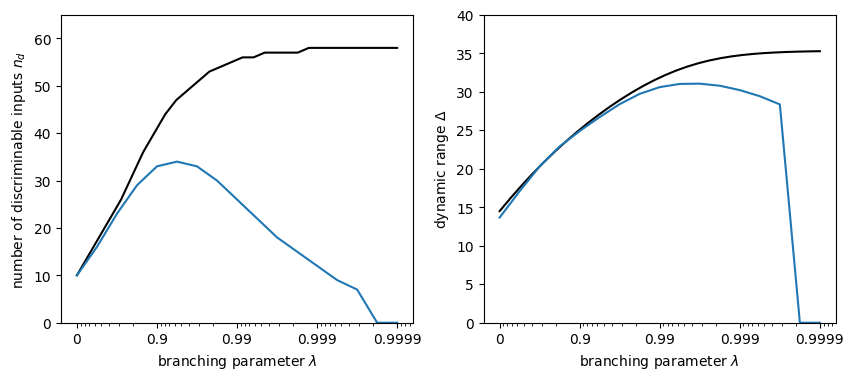

In [104]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_mf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_mf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
